In [1]:
# !pip install shap
# !pip install shap scikit-learn
# !pip install statsmodels

In [2]:
import pandas as pd
from pymongo import MongoClient
import matplotlib.pyplot as plt
import seaborn as sns
from pandas import json_normalize

from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, roc_auc_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# import shap
# shap.initjs()

In [3]:
# Connect to MongoDB
from pymongo import MongoClient
conn = MongoClient()

In [4]:
# List datbases in Mongo
conn.list_database_names()

['admin', 'config', 'local', 'my_new_database', 'mydb', 'new_db']

In [5]:
# Choose our databse
db = conn.new_db

In [6]:
# List collections in our database
db.list_collection_names()

['new_collection']

In [7]:
# Fetch data
data = list(db.new_collection.find())

In [8]:
#transform nested JSON data into a flat table or a Pandas DataFrame
df = json_normalize(data)

In [9]:
# df = df.drop('_id', axis=1)
df = df.drop(['_id'], axis=1)

In [10]:
# change previous to categorical  
df['previous'] = df['previous'].astype('object')

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4118 entries, 0 to 4117
Data columns (total 20 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             4118 non-null   int64  
 1   job             4118 non-null   object 
 2   marital         4118 non-null   object 
 3   education       4118 non-null   object 
 4   housing         4118 non-null   object 
 5   loan            4118 non-null   object 
 6   contact         4118 non-null   object 
 7   month           4118 non-null   object 
 8   day_of_week     4118 non-null   object 
 9   duration        4118 non-null   int64  
 10  campaign        4118 non-null   int64  
 11  pdays           4118 non-null   int64  
 12  previous        4118 non-null   object 
 13  poutcome        4118 non-null   object 
 14  emp_var_rate    4118 non-null   float64
 15  cons_price_idx  4118 non-null   float64
 16  cons_conf_idx   4118 non-null   float64
 17  euribor3m       4118 non-null   f

In [12]:
df.columns

Index(['age', 'job', 'marital', 'education', 'housing', 'loan', 'contact',
       'month', 'day_of_week', 'duration', 'campaign', 'pdays', 'previous',
       'poutcome', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx',
       'euribor3m', 'nr_employed', 'y'],
      dtype='object')

In [13]:
df.head()

,age,job,marital,education,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,y
0,0,student,single,basic.4y,no,yes,cellular,apr,wed,371,2,999,0,nonexistent,-1.8,93.075,-47.1,1.405,5099.1,1
1,0,student,single,basic.4y,yes,no,cellular,sep,wed,396,2,6,3,success,-1.1,94.199,-37.5,0.876,4963.6,1
2,0,student,single,basic.6y,yes,no,cellular,sep,thu,161,2,6,4,success,-1.1,94.199,-37.5,0.879,4963.6,1
3,0,student,single,basic.9y,no,yes,telephone,jul,mon,567,1,6,2,success,-1.7,94.215,-40.3,0.827,4991.6,1
4,0,student,single,basic.9y,yes,no,cellular,aug,tue,642,1,999,0,nonexistent,-2.9,92.201,-31.4,0.884,5076.2,1


One of the age values has not changed to a discrete one, let's get rid of it

In [14]:
df['age'].value_counts()

age
1     2288
2     1566
3      247
0       16
48       1
Name: count, dtype: int64

In [15]:
df = df[df.age != 48]

In [16]:
df['previous'].value_counts()

previous
0    3200
1     655
2     173
3      63
4      17
5       8
6       1
Name: count, dtype: int64

In [17]:
df['y'].value_counts()

y
1    2059
0    2058
Name: count, dtype: int64

--------------------------------------------

Now the data is ready we start with the ML model

In [17]:
categorical_cols = ['job', 'marital', 'education', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome', 'previous']
target_col = 'y' #term deposit

In [18]:
# One-hot encode the categorical features
df_encoded = pd.get_dummies(df, columns=categorical_cols)

In [19]:
# Separate features and target
X = df_encoded.drop(columns=[target_col])
y = df_encoded[target_col]

In [20]:
# Check for NaN values in X and y
print("NaN values in X:")
print(X.isnull().sum())

print("\nNaN values in y:")
print(y.isnull().sum())

NaN values in X:
age             0
duration        0
campaign        0
pdays           0
emp_var_rate    0
               ..
previous_2      0
previous_3      0
previous_4      0
previous_5      0
previous_6      0
Length: 63, dtype: int64

NaN values in y:
0


There are no NAN values, we go on

In [21]:
# Check if there are enough samples after cleaning
n_samples = len(X)
if n_samples == 0:
    raise ValueError("After preprocessing, there are no samples available.")

In [22]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [23]:
# Create a pipeline to scale the data and then apply logistic regression
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('logreg', LogisticRegression(random_state=42, class_weight='balanced', solver='liblinear', max_iter=1000))
])

In [24]:
# Fit the model
pipeline.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('logreg',
                 LogisticRegression(class_weight='balanced', max_iter=1000,
                                    random_state=42, solver='liblinear'))])

In [25]:
# Predict on the test set
y_pred_lr = pipeline.predict(X_test)

In [26]:
# Evaluation
print("\nClassification Report:")
print(classification_report(y_test, y_pred_lr, zero_division=0))


Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.84      0.87       396
           1       0.86      0.91      0.88       428

    accuracy                           0.88       824
   macro avg       0.88      0.87      0.87       824
weighted avg       0.88      0.88      0.87       824



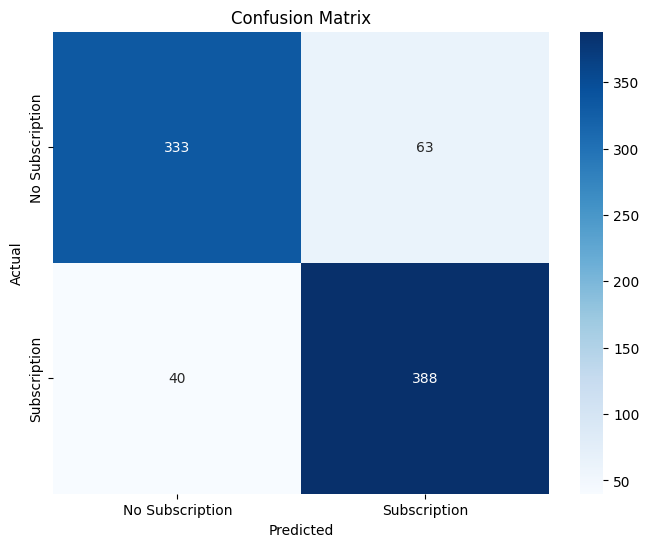

In [27]:
# Confusion Matrix
# print('Confusion Matrix:\n', confusion_matrix(y_test, y_pred_lr))
cm = confusion_matrix(y_test, y_pred_lr)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Subscription', 'Subscription'], yticklabels=['No Subscription', 'Subscription'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [28]:
print('Accuracy:', accuracy_score(y_test, y_pred_lr))

Accuracy: 0.875


In [29]:
# Extract coefficients from the logistic regression model
logreg_model = pipeline.named_steps['logreg']
coefficients = logreg_model.coef_[0]
feature_names = X.columns

In [30]:
# Create a DataFrame to interpret coefficients
coef_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})

In [31]:
# Filter for job-related coefficients
prev_coef_df = coef_df[coef_df['Feature'].str.startswith('previous_')]

In [32]:
prev_coef_df = prev_coef_df.sort_values(by='Coefficient', ascending=False)

In [33]:
print("Logistic Regression Coefficients for Previous number of contacts:")
print(prev_coef_df)

Logistic Regression Coefficients for Previous number of contacts:
       Feature  Coefficient
60  previous_4     0.211245
61  previous_5     0.159803
56  previous_0     0.084368
58  previous_2    -0.007337
59  previous_3    -0.047604
57  previous_1    -0.122461
62  previous_6    -0.159183


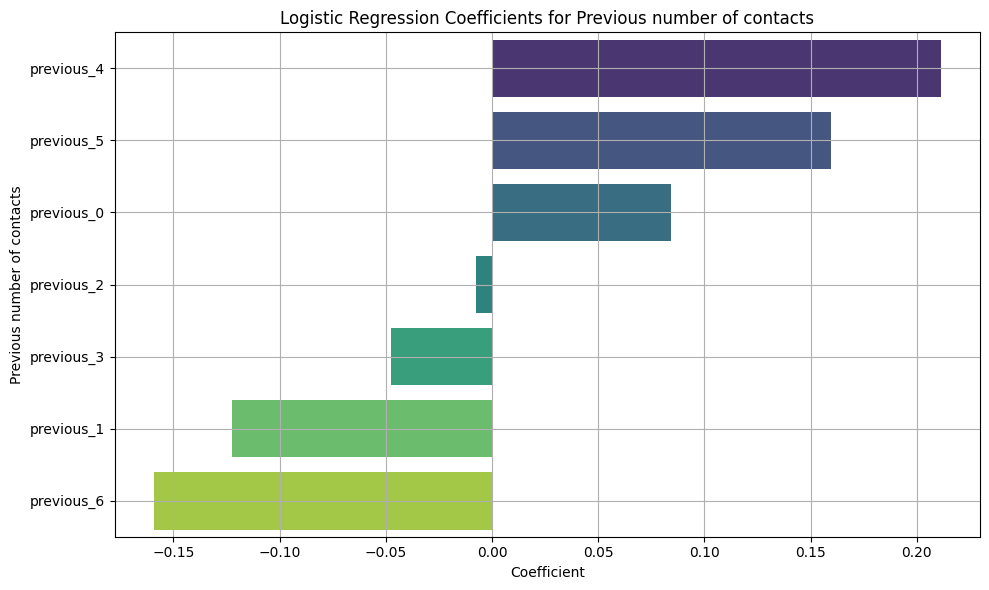

In [34]:
# Plotting
plt.figure(figsize=(10, 6))
sns.barplot(x='Coefficient', y='Feature', data=prev_coef_df, hue='Feature', dodge=False, palette='viridis', legend=False)
plt.title('Logistic Regression Coefficients for Previous number of contacts')
plt.xlabel('Coefficient')
plt.ylabel('Previous number of contacts')
plt.grid(True)
plt.tight_layout()
plt.show()

In [51]:
# Categorical columns to be encoded
categorical_cols = ['job', 'marital', 'education', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome']

In [52]:
# One-hot encoding the categorical columns
df_encoded = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

In [53]:
# Ensure all columns are in numerical format
df_encoded = df_encoded.apply(pd.to_numeric)

In [54]:
# Split the data into training and testing sets
X = df_encoded.drop(columns=['y'])
y = df_encoded['y']

In [55]:
# Check for NaN values in X and y
print("NaN values in X:")
print(X.isnull().sum())

print("\nNaN values in y:")
print(y.isnull().sum())

NaN values in X:
age                              0
duration                         0
campaign                         0
pdays                            0
previous                         0
emp_var_rate                     0
cons_price_idx                   0
cons_conf_idx                    0
euribor3m                        0
nr_employed                      0
job_blue-collar                  0
job_entrepreneur                 0
job_housemaid                    0
job_management                   0
job_other                        0
job_retired                      0
job_self-employed                0
job_services                     0
job_student                      0
job_technician                   0
job_unemployed                   0
marital_married                  0
marital_single                   0
education_basic.6y               0
education_basic.9y               0
education_high.school            0
education_illiterate             0
education_none                   0
edu

In [56]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [57]:
lr_model = LogisticRegression(max_iter=1000)

lr_model.fit(X_train, y_train)
y_pred = lr_model.predict(X_test)
y_proba = lr_model.predict_proba(X_test)[:, 1]
accuracy = accuracy_score(y_test, y_pred)
roc_auc1 = roc_auc_score(y_test, y_proba)
fpr1, tpr1, thresholds1 = roc_curve(y_test, y_proba)

print("Model: Logistic Regression")
print(f"Accuracy: {accuracy}")
print(f"ROC AUC: {roc_auc1}")
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("Classification Report:")
print(classification_report(y_test, y_pred))
print("\n")

Model: Logistic Regression
Accuracy: 0.8624595469255664
ROC AUC: 0.9326329901442233
Confusion Matrix:
[[519  95]
 [ 75 547]]
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.85      0.86       614
           1       0.85      0.88      0.87       622

    accuracy                           0.86      1236
   macro avg       0.86      0.86      0.86      1236
weighted avg       0.86      0.86      0.86      1236





In [58]:
rf_model = RandomForestClassifier()

rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)
y_proba = rf_model.predict_proba(X_test)[:, 1]
accuracy = accuracy_score(y_test, y_pred)
roc_auc2 = roc_auc_score(y_test, y_proba)
fpr2, tpr2, thresholds2 = roc_curve(y_test, y_proba)

print("Model: Randomforest")
print(f"Accuracy: {accuracy}")
print(f"ROC AUC: {roc_auc2}")
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("Classification Report:")
print(classification_report(y_test, y_pred))
print("\n")

Model: Randomforest
Accuracy: 0.8810679611650486
ROC AUC: 0.9335703886799962
Confusion Matrix:
[[517  97]
 [ 50 572]]
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.84      0.88       614
           1       0.86      0.92      0.89       622

    accuracy                           0.88      1236
   macro avg       0.88      0.88      0.88      1236
weighted avg       0.88      0.88      0.88      1236





In [59]:
svm_model = SVC(probability=True)

svm_model.fit(X_train, y_train)
y_pred = svm_model.predict(X_test)
y_proba = svm_model.predict_proba(X_test)[:, 1]
accuracy = accuracy_score(y_test, y_pred)
roc_auc3 = roc_auc_score(y_test, y_proba)
fpr3, tpr3, thresholds3 = roc_curve(y_test, y_proba)

print("Model: SVM")
print(f"Accuracy: {accuracy}")
print(f"ROC AUC: {roc_auc3}")
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("Classification Report:")
print(classification_report(y_test, y_pred))
print("\n")

Model: SVM
Accuracy: 0.8090614886731392
ROC AUC: 0.9037412151617666
Confusion Matrix:
[[538  76]
 [160 462]]
Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.88      0.82       614
           1       0.86      0.74      0.80       622

    accuracy                           0.81      1236
   macro avg       0.81      0.81      0.81      1236
weighted avg       0.82      0.81      0.81      1236





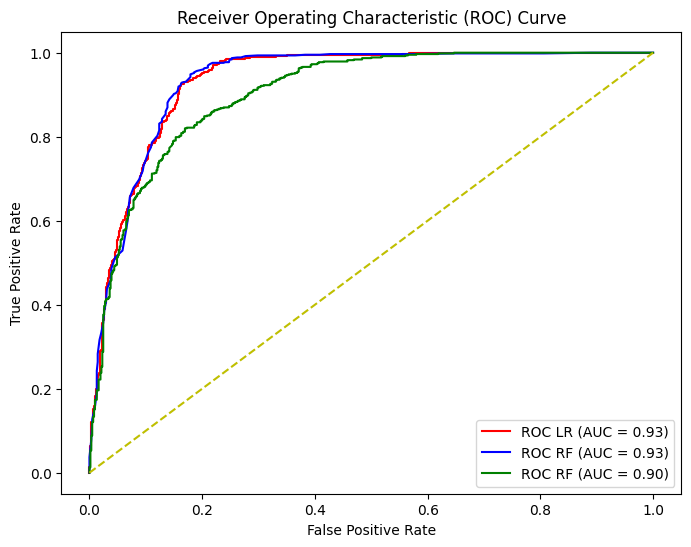

In [60]:
plt.figure(figsize=(8, 6))
plt.plot(fpr1, tpr1, label=f'ROC LR (AUC = {roc_auc1:.2f})',color='r')
plt.plot(fpr2, tpr2, label=f'ROC RF (AUC = {roc_auc2:.2f})',color='b')
plt.plot(fpr3, tpr3, label=f'ROC RF (AUC = {roc_auc3:.2f})',color='g')
plt.plot([0, 1], [0, 1], linestyle='--', color='y')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

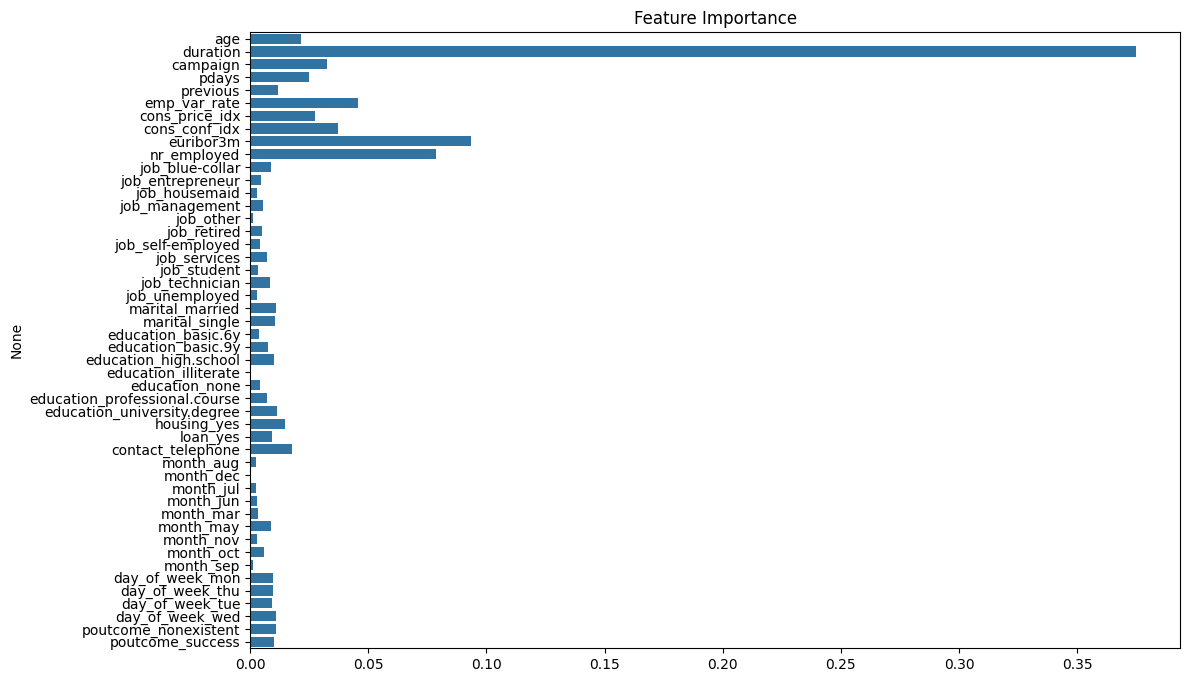

In [63]:
# Plotting the feature importance for Random Forest
importance = rf_model.feature_importances_
features = X.columns
plt.figure(figsize=(12, 8))
sns.barplot(x=importance, y=features)
plt.title('Feature Importance')
plt.show()